In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import warnings

warnings.filterwarnings("ignore")  # 경고 문구 생략

train_path = "../../data/train/"
test_path = "../../data/validation/"

train_label = pd.read_csv(train_path + "label/1.걸음걸이/training_label.csv")
train_sleep = pd.read_csv(train_path + "raw/train_sleep.csv")
train_activity = pd.read_csv(train_path + "raw/train_activity.csv")

test_label = pd.read_csv(test_path + "label/1.걸음걸이/val_label.csv")
test_sleep = pd.read_csv(test_path + "raw/val_sleep.csv")
test_activity = pd.read_csv(test_path + "raw/val_activity.csv")

In [2]:
random_seed = 42

In [3]:
label_encoder = {"CN": 0, "MCI": 1, "Dem": 2}

In [4]:
train_label["label"] = train_label["DIAG_NM"].map(label_encoder)
test_label["label"] = test_label["DIAG_NM"].map(label_encoder)
train_label.drop(columns=["DIAG_NM"], inplace=True)
test_label.drop(columns=["DIAG_NM"], inplace=True)

In [5]:
# label 과 합치기
train = train_sleep.merge(train_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")
test = test_sleep.merge(test_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")

# sleep + activity
train = pd.concat([train, train_activity.drop(["EMAIL"], axis=1)], axis=1)
test = pd.concat([test, test_activity.drop(["EMAIL"], axis=1)], axis=1)

train.drop(columns=["SAMPLE_EMAIL"], inplace=True)
test.drop(columns=["SAMPLE_EMAIL"], inplace=True)

## 데이터 합치기

In [6]:
all_data = pd.concat([train, test], axis=0)
all_data = all_data.drop(["label"], axis=1)  # 타겟값 제거

In [7]:
all_data.columns

Index(['EMAIL', 'sleep_awake', 'sleep_bedtime_end', 'sleep_bedtime_start',
       'sleep_breath_average', 'sleep_deep', 'sleep_duration',
       'sleep_efficiency', 'sleep_hr_5min', 'sleep_hr_average',
       'sleep_hr_lowest', 'sleep_hypnogram_5min', 'sleep_is_longest',
       'sleep_light', 'sleep_midpoint_at_delta', 'sleep_midpoint_time',
       'sleep_onset_latency', 'sleep_period_id', 'sleep_rem', 'sleep_restless',
       'sleep_rmssd', 'sleep_rmssd_5min', 'sleep_score',
       'sleep_score_alignment', 'sleep_score_deep', 'sleep_score_disturbances',
       'sleep_score_efficiency', 'sleep_score_latency', 'sleep_score_rem',
       'sleep_score_total', 'sleep_temperature_delta',
       'sleep_temperature_deviation', 'sleep_total',
       'CONVERT(sleep_hr_5min USING utf8)',
       'CONVERT(sleep_hypnogram_5min USING utf8)',
       'CONVERT(sleep_rmssd_5min USING utf8)', 'activity_average_met',
       'activity_cal_active', 'activity_cal_total', 'activity_class_5min',
       'activit

# 데이터 전처리

## sleep_startpoint_at_delta 컬럼 추가

In [8]:
from datetime import datetime


# 자정과 timestamp의 차이(초)
def time_to_seconds_since_midnight(timestamp):
    dt = datetime.fromisoformat(timestamp[:-6])  # +09:00 타임존 offset 제거
    return dt.hour * 3600 + dt.minute * 60 + dt.second


all_data["sleep_startpoint_at_delta"] = all_data["sleep_bedtime_start"].apply(
    time_to_seconds_since_midnight
)

## startpoint_at_delta, midpoint_at_delta 자정 전의 시간이면 음수를 갖도록 수정

In [9]:
def adjust_delta_time(time):
    if time > 43200:
        time -= 86400
    return time


all_data["sleep_startpoint_at_delta"] = all_data["sleep_startpoint_at_delta"].apply(
    adjust_delta_time
)
all_data["sleep_midpoint_at_delta"] = all_data["sleep_midpoint_at_delta"].apply(
    adjust_delta_time
)

In [10]:
all_data[["sleep_bedtime_start", "sleep_startpoint_at_delta"]]

,sleep_bedtime_start,sleep_startpoint_at_delta
0,2020-10-18T18:38:28+09:00,-19292
1,2020-10-19T21:39:52+09:00,-8408
2,2020-10-20T20:51:28+09:00,-11312
3,2020-10-21T22:08:16+09:00,-6704
4,2020-10-22T20:38:30+09:00,-12090
...,...,...
2473,2021-02-12T00:11:11+09:00,671
2474,2021-02-12T21:46:01+09:00,-8039
2475,2021-02-14T21:40:10+09:00,-8390
2476,2021-02-15T19:41:02+09:00,-15538


# Feature Engineering

## sleep_consistency 파생 변수 생성

### bedtime_start, midpoint_at_delta 컬럼 sin, cos 변환

In [11]:
# 24시간 순환성을 가지도록
all_data["sleep_startpoint_at_delta_sin"] = np.sin(
    2 * np.pi * all_data["sleep_startpoint_at_delta"] / 86400
)
all_data["sleep_startpoint_at_delta_cos"] = np.cos(
    2 * np.pi * all_data["sleep_startpoint_at_delta"] / 86400
)

all_data["sleep_midpoint_at_delta_sin"] = np.sin(
    2 * np.pi * all_data["sleep_midpoint_at_delta"] / 86400
)
all_data["sleep_midpoint_at_delta_cos"] = np.cos(
    2 * np.pi * all_data["sleep_midpoint_at_delta"] / 86400
)

### 개인별 delta time sin, cos 벡터의 평균 길이 계산
- 모든 벡터가 동일한 방향(즉, 같은 시간대)에 있으면 평균 벡터 길이 = 1
- 시간 차이가 많이날수록 두 벡터의 평균 길이는 짧아짐

<br><br>

- 완벽한 consistency -> MRL = 1
- 일정하지 않은 패턴 -> MRL < 1
- 완전히 랜덤한 패턴 -> MRL = 0

In [12]:
all_data["sleep_startpoint_at_delta_sin_cumsum"] = all_data.groupby("EMAIL")[
    "sleep_startpoint_at_delta_sin"
].cumsum()
all_data["sleep_startpoint_at_delta_cos_cumsum"] = all_data.groupby("EMAIL")[
    "sleep_startpoint_at_delta_cos"
].cumsum()
all_data["sleep_midpoint_at_delta_sin_cumsum"] = all_data.groupby("EMAIL")[
    "sleep_midpoint_at_delta_sin"
].cumsum()
all_data["sleep_midpoint_at_delta_cos_cumsum"] = all_data.groupby("EMAIL")[
    "sleep_midpoint_at_delta_cos"
].cumsum()
all_data["date_count"] = (
    all_data.groupby("EMAIL").cumcount() + 1
)  # cumcount 는 0부터 시작

In [13]:
# mrl: mean resultant length: 벡터들 평균 길이
all_data["sleep_startpoint_at_delta_mrl"] = (
    np.sqrt(
        all_data["sleep_startpoint_at_delta_sin_cumsum"] ** 2
        + all_data["sleep_startpoint_at_delta_cos_cumsum"] ** 2
    )
    / all_data["date_count"]
)
all_data["sleep_midpoint_at_delta_mrl"] = (
    np.sqrt(
        all_data["sleep_midpoint_at_delta_sin_cumsum"] ** 2
        + all_data["sleep_midpoint_at_delta_cos_cumsum"] ** 2
    )
    / all_data["date_count"]
)

### sleep_consistency

In [14]:
def fill_na_with_user_median(df, column_name):
    """
    shift, moving average 계산으로 비어있는 앞의 값 평균으로 채우기 개별 사용자의 중앙값으로 채운다.
    """
    # 사용자별 평균 계산
    user_medians = df.groupby("EMAIL")[column_name].transform("median")

    # NaN 값을 해당 사용자의 중앙값으로 채움
    df[column_name].fillna(user_medians, inplace=True)
    return df

In [15]:
def generate_time_lag_features(df, column, lags=[2, 3], rolling_windows=[3, 7, 30]):
    """
    특정 컬럼(column)에 대해 Time Lag 변수와 이동 평균 변수를 생성하는 함수.

    Parameters:
    - df: DataFrame
    - column: 타겟 컬럼명 (예: 'deep_ratio_5h' 또는 'awake_ratio_5h')
    - lags: Time Lag을 만들 간격 리스트 (기본값: [2, 3])
    - rolling_windows: 이동 평균을 계산할 윈도우 크기 리스트 (기본값: [3, 7, 30])

    Returns:
    - 변형된 DataFrame (원본 df에 새로운 컬럼 추가)
    """
    for lag in lags:
        df[f"{column}_lag{lag}"] = df.groupby("EMAIL")[column].shift(lag)
        df = fill_na_with_user_median(df, f"{column}_lag{lag}")

    for window in rolling_windows:
        df[f"{column}_{window}d_avg"] = df.groupby("EMAIL")[column].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df = fill_na_with_user_median(df, f"{column}_{window}d_avg")
    return df

In [16]:
all_data["sleep_consistency"] = (
    all_data["sleep_startpoint_at_delta_mrl"] + all_data["sleep_midpoint_at_delta_mrl"]
) / 2

all_data = generate_time_lag_features(all_data, "sleep_consistency")

## bedtime_start, bedtime_end 시간대, 요일 변수 추가

In [17]:
all_data["sleep_bedtime_start"] = pd.to_datetime(all_data["sleep_bedtime_start"])
all_data["sleep_bedtime_end"] = pd.to_datetime(all_data["sleep_bedtime_end"])

all_data["sleep_start_hour"] = all_data["sleep_bedtime_start"].dt.hour
all_data["sleep_start_weekday"] = all_data["sleep_bedtime_start"].dt.weekday

all_data["sleep_end_hour"] = all_data["sleep_bedtime_end"].dt.hour
all_data["sleep_end_weekday"] = all_data["sleep_bedtime_end"].dt.weekday

## 수면 단계별 ratio

In [18]:
all_data["sleep_deep_ratio"] = all_data["sleep_deep"] / all_data["sleep_total"]
all_data["sleep_light_ratio"] = all_data["sleep_light"] / all_data["sleep_total"]
all_data["sleep_awake_ratio"] = all_data["sleep_awake"] / all_data["sleep_duration"]
all_data["sleep_rem_ratio"] = all_data["sleep_rem"] / all_data["sleep_total"]

all_data = generate_time_lag_features(all_data, "sleep_deep_ratio")
all_data = generate_time_lag_features(all_data, "sleep_light_ratio")
all_data = generate_time_lag_features(all_data, "sleep_awake_ratio")
all_data = generate_time_lag_features(all_data, "sleep_rem_ratio")

## 수면 초반 5시간 동안의 deep과 awake 비율 

In [19]:
def clean_hypnogram(hypnogram_str):
    hypnogram = list(map(int, hypnogram_str.rstrip("/").split("/")))
    return hypnogram

In [20]:
def calculate_deep_awake_ratio(hypnogram):
    # 5시간(300분) 동안의 데이터만 사용 (5분 단위로 기록된 데이터이므로 60개의 데이터)
    hypnogram = clean_hypnogram(hypnogram)[:60]

    deep_count = hypnogram.count("1")
    awake_count = hypnogram.count("4")

    total_count = len(hypnogram)

    deep_ratio = deep_count / total_count
    awake_ratio = awake_count / total_count

    return (deep_ratio, awake_ratio)


all_data[["deep_ratio_5h", "awake_ratio_5h"]] = all_data[
    "CONVERT(sleep_hypnogram_5min USING utf8)"
].apply(lambda x: pd.Series(calculate_deep_awake_ratio(x)))

In [21]:
all_data = generate_time_lag_features(all_data, "deep_ratio_5h")
all_data = generate_time_lag_features(all_data, "awake_ratio_5h")

## 최대 연속 깨어난 시간, 평균 깨어난 간격

In [22]:
def extract_awake_features(hypnogram):
    hypnogram = clean_hypnogram(hypnogram)

    # 깨어난 횟수 (4의 개수)
    awake_count = hypnogram.count(4)

    # 최대 연속 깨어난 시간 (연속된 4의 최대 길이)
    max_awake_streak = (
        max(map(len, "".join(map(str, hypnogram)).split("4"))) if awake_count > 0 else 0
    )

    # 평균 깨어난 간격 (전체 수면 시간에서 깨어난 횟수로 나눔, 단위: 초)
    awake_interval_avg = (len(hypnogram) * 300) / awake_count if awake_count > 0 else 0

    return max_awake_streak, awake_interval_avg


all_data[["awake_longest_duration", "awake_interval_avg"]] = all_data[
    "CONVERT(sleep_hypnogram_5min USING utf8)"
].apply(lambda x: pd.Series(extract_awake_features(x)))

all_data = generate_time_lag_features(all_data, "awake_longest_duration")
all_data = generate_time_lag_features(all_data, "awake_interval_avg")

## 필요없는 피처 제거

In [23]:
drop_features = [
    "sleep_hr_5min",
    "sleep_rmssd_5min",
    "sleep_hypnogram_5min",
    "sleep_period_id",
    "sleep_is_longest",
    "EMAIL",
    "sleep_is_longest",
    "sleep_rmssd",
    "sleep_score",
    "sleep_score_alignment",
    "sleep_temperature_delta",
    "sleep_temperature_deviation",
    "sleep_startpoint_at_delta_mrl",
    "sleep_midpoint_at_delta_mrl",
    "sleep_startpoint_at_delta_sin_cumsum",
    "sleep_startpoint_at_delta_cos_cumsum",
    "sleep_midpoint_at_delta_sin_cumsum",
    "sleep_midpoint_at_delta_sin_cumsum",
    "sleep_startpoint_at_delta_sin",
    "sleep_startpoint_at_delta_cos",
    "sleep_midpoint_at_delta_sin",
    "sleep_midpoint_at_delta_sin",
    "sleep_deep",
    "sleep_light",
    "sleep_awake",
    "sleep_rem",
    "sleep_efficiency",
    "sleep_score_efficiency",
    "sleep_score_deep",
    "sleep_score_rem",
    "sleep_score_light",
]

remaining_features = all_data.columns.difference(drop_features)

all_data = all_data[remaining_features]
all_data = all_data.select_dtypes(include=[int, float])  # 숫자형 데이터만
selected_features = all_data.columns

In [24]:
selected_features

Index(['activity_average_met', 'activity_cal_active', 'activity_cal_total',
       'activity_daily_movement', 'activity_high', 'activity_inactive',
       'activity_inactivity_alerts', 'activity_low', 'activity_medium',
       'activity_met_min_high', 'activity_met_min_inactive',
       'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear',
       'activity_rest', 'activity_score', 'activity_score_meet_daily_targets',
       'activity_score_move_every_hour', 'activity_score_recovery_time',
       'activity_score_stay_active', 'activity_score_training_frequency',
       'activity_score_training_volume', 'activity_steps', 'activity_total',
       'awake_interval_avg', 'awake_interval_avg_30d_avg',
       'awake_interval_avg_3d_avg', 'awake_interval_avg_7d_avg',
       'awake_interval_avg_lag2', 'awake_interval_avg_lag3',
       'awake_longest_duration', 'awake_longest_duration_30d_avg',
       'awake_longest_duration_3d_avg', 'awake_longest_duration_7d_avg',
       'awak

## 데이터 다운캐스팅

In [25]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2  # 1MB = 1024**2 Byte
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object":
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast="integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast="float")
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print("{:.1f}% 압축됨".format(100 * (start_mem - end_mem) / start_mem))

    return df


all_data = downcast(all_data)

64.0% 압축됨


## 데이터 스케일링

In [26]:
from sklearn.preprocessing import StandardScaler

all_data = StandardScaler().fit_transform(all_data)

## 데이터 나누기

In [27]:
num_train = len(train)

X = all_data[:num_train]
X_test = all_data[num_train:]

y = train["label"].values
y_test = test["label"].values

# SMOTE

Text(0, 0.5, 'Percentage (%)')

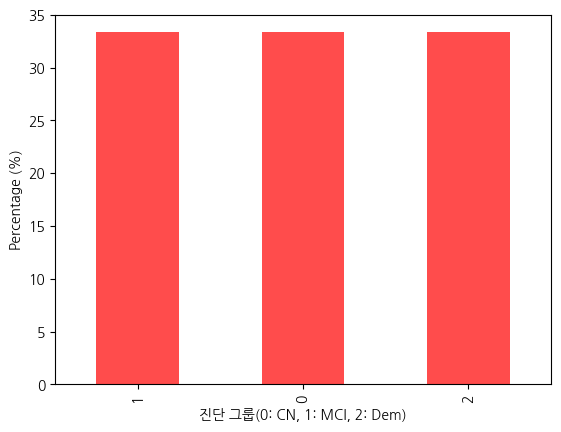

In [28]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=random_seed)
X_resampled, y_resampled = smote.fit_resample(X, y)

class_distribution_after = pd.Series(y_resampled).value_counts(normalize=True) * 100
class_distribution_after.plot(kind="bar", color="red", alpha=0.7)
plt.xlabel("진단 그룹(0: CN, 1: MCI, 2: Dem)")
plt.ylabel("Percentage (%)")

# 모델 훈련 및 성능 검증

In [29]:
n_splits = 5

In [30]:
from sklearn.model_selection import StratifiedKFold

# shuffle: 훈련 데이터가 시계열 데이터가 아니라면 섞어주는 것이 좋음
# 시계열 데이터는 순서가 중요해서 데이터를 섞으면 안도미
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# 모델 학습 및 평가
models = {
    "Lasso Regression": LogisticRegression(
        penalty="l1", solver="liblinear", multi_class="ovr"
    ),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "Support Vector Machine": SVC(  # probability=False 모델 학습 시간 줄이기 위해
        kernel="linear", probability=False, random_state=random_seed
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed),
}

In [33]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from joblib import Parallel, delayed

models_ = {}


def evaluate_model(name, model, folds, X_resampled, y_resampled):
    acc_scores = []
    f1_scores = []
    class_report_list = []

    for fold, (train_idx, val_idx) in enumerate(folds.split(X_resampled, y_resampled)):
        # 데이터 분할
        X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

        # 모델 학습
        model.fit(X_train, y_train)

        # 모델 예측
        y_pred = model.predict(X_val)

        # 평가
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average="weighted")  # 불균형 데이터 고려
        acc_scores.append(acc)
        f1_scores.append(f1)

        # Classification Report 저장
        report = classification_report(y_val, y_pred, output_dict=True)
        class_report_list.append(pd.DataFrame(report).T)

    # Classification Report 평균
    avg_class_report = pd.concat(class_report_list).groupby(level=0).mean()

    # Accuracy 및 F1-score 평균 출력
    print("#" * 40, f"Model: {name}", "#" * 40)
    print(f"=== Average Classification Report ===")
    print(avg_class_report)
    print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Average F1-score: {np.mean(f1_scores):.4f}")
    print("=" * 60)

    return name, model


results = Parallel(n_jobs=-1)(
    delayed(evaluate_model)(name, model, folds, X_resampled, y_resampled)
    for name, model in models.items()
)

for name, model in results:
    models_[name] = model

######################################## Model: Decision Tree ########################################
=== Average Classification Report ===
              precision    recall  f1-score     support
0              0.907904  0.891194  0.899427  1156.20000
1              0.894248  0.903658  0.898862  1156.20000
2              0.980280  0.987893  0.984055  1156.20000
accuracy       0.927580  0.927580  0.927580     0.92758
macro avg      0.927478  0.927582  0.927448  3468.60000
weighted avg   0.927478  0.927580  0.927447  3468.60000
Average Accuracy: 0.9276
Average F1-score: 0.9274
######################################## Model: Support Vector Machine ########################################
=== Average Classification Report ===
              precision    recall  f1-score      support
0              0.652920  0.570490  0.608713  1156.200000
1              0.609007  0.668049  0.637111  1156.200000
2              0.832621  0.856084  0.844045  1156.200000
accuracy       0.698207  0.698207  0.69

## test dataset 예측 결과

In [34]:
# Test Set 성능 평가
print("\n", "=" * 40, "TEST SET EVALUATION", "=" * 40, "\n")

for name, model in models_.items():
    print(f"=== Evaluating {name} on Test Set ===")

    # 테스트 데이터 예측
    y_test_pred = model.predict(X_test)

    # 테스트 데이터 평가
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")  # 불균형 고려
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # 결과 출력
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test Classification Report:\n", pd.DataFrame(test_report).T)
    print("=" * 60)


 ======================================== TEST SET EVALUATION ======================================== 

=== Evaluating Lasso Regression on Test Set ===
Test Accuracy: 0.4944
Test F1-score: 0.5578
Test Classification Report:
               precision    recall  f1-score     support
0              0.791634  0.522495  0.629504  1956.00000
1              0.101344  0.318182  0.153725   308.00000
2              0.477273  0.490654  0.483871   214.00000
accuracy       0.494350  0.494350  0.494350     0.49435
macro avg      0.456750  0.443777  0.422367  2478.00000
weighted avg   0.678687  0.494350  0.557791  2478.00000
=== Evaluating Decision Tree on Test Set ===
Test Accuracy: 0.5747
Test F1-score: 0.6213
Test Classification Report:
               precision    recall  f1-score      support
0              0.798083  0.638548  0.709458  1956.000000
1              0.120466  0.301948  0.172222   308.000000
2              0.581560  0.383178  0.461972   214.000000
accuracy       0.574657  0.574657  